In [89]:
import pandas as pd
import numpy as np
import networkx as nx
from itertools import combinations
import os
import seaborn as sns
import statistics as stat
from collections import Counter
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
from community import community_louvain
import random

In [90]:
def read():
    df = pd.read_csv("../data/analysis/cprr_new_orleans_pd_ipm.csv")
    return df

In [91]:
def read_uof():
    df = pd.read_csv("../data/clean/uof_new_orleans_pd_2016_2021.csv")
    return df

df_uof = read_uof()

df_uof = df_uof[["tracking_id", "uid", "first_name", "last_name", "use_of_force_level", "division", "unit"]] 
df_uof.columns

Index(['tracking_id', 'uid', 'first_name', 'last_name', 'use_of_force_level',
       'division', 'unit'],
      dtype='object')

In [92]:
def read_sas():
    df = pd.read_csv("../data/clean/sas_new_orleans_pd_2010_2021.csv")
    return df

df_sas = read_sas()
df_sas = df_sas[["tracking_id", "first_name", "last_name", "stop_results"]]
df_sas.columns

C:\Users\PC\AppData\Local\Temp\ipykernel_13396\2813089376.py:2: DtypeWarning: Columns (32) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/clean/sas_new_orleans_pd_2010_2021.csv")


Index(['tracking_id', 'item_number', 'district', 'zone', 'stop_reason',
       'vehicle_year', 'vehicle_make', 'vehicle_model', 'vehicle_style',
       'vehicle_color', 'zip_code', 'stop_and_search_location', 'id',
       'stop_and_search_interview_id_2', 'vehicle_number', 'assigned_district',
       'assigned_department', 'stop_results', 'subject_type',
       'search_occurred', 'evidence_seized', 'evidence_types',
       'strip_body_cavity_search', 'legal_basis', 'consent_to_search',
       'consent_form_completed', 'search_types', 'exit_vehicle', 'rank_desc',
       'first_name', 'middle_name', 'last_name', 'badge_number',
       'stop_and_search_year', 'stop_and_search_month', 'stop_and_search_day',
       'stop_and_search_time', 'agency', 'uid', 'stop_and_search_uid',
       'tracking_id_og'],
      dtype='object')

In [95]:
df = read(
df.shape

df = df.rename(columns={"pib_control_number": "tracking_id", 
                        "officer_sex_x": "officer_x", "officer_race_x": "officer_race", 
                        "title": "rank_desc", "officer_division_x": "officer_division", 
                        "officer_sub_division_a_x": "officer_sub_division_a"})

df = df[["tracking_id", "uid", "first_name", "last_name", "birth_year", 
         "officer_division", "officer_sub_division_a", "rank_desc",
         "citizen_age", "citizen_sex", "citizen_race", 
         "allegation", "allegation_directive", "occurred_date", "county"]]

SyntaxError: invalid syntax (2106943425.py, line 4)

In [ ]:
def drop_rows_missing_names(df):
    df.loc[:, "last_name"] = df.last_name.str.replace(r"((.+)?unknown(.+)?|none|complaint operator|not(.+)?nopd(.+)?)", "", regex=True)
    return df[~((df.last_name.fillna("") == ""))]

df = df.pipe(drop_rows_missing_names)
df.last_name.unique()

array(['johnson', 'known', 'lentz', ..., 'mcelveen', 'oconnor', 'moua'],
      dtype=object)

In [ ]:
# remove outliers 
df = df[~df.tracking_id.isin(df.tracking_id.value_counts().loc[lambda x: x >= 30 ].index)]

In [ ]:
d0 = df.groupby('tracking_id').count()
d1 = d0[d0.uid > 1]
group_complaints = list(set(d1.index))


df["count"] = 1
df_perUID = df.drop_duplicates(subset=["tracking_id", "uid"])
df_perUID = df_perUID.pivot_table(index=["tracking_id"], values=["count"], aggfunc="sum").reset_index()
df_perUID = df_perUID.rename(columns={"count": "no_of_officers"})
df_perUID

dict_PerComplaint = dict(zip(df_perUID.tracking_id, df_perUID.no_of_officers))

g = nx.Graph()
for incident in group_complaints:
    numberPer = dict_PerComplaint.get(incident)
    node_pairs = list(combinations(df[df.tracking_id == incident]['uid'].tolist(), 2))
    for node_pair in node_pairs:
        if g.has_edge(node_pair[0], node_pair[1]):
            g[node_pair[0]][node_pair[1]]['weight'] += (1+1/numberPer)
        else:
            g.add_edge(node_pair[0], node_pair[1], weight = (1+1/numberPer))
    if group_complaints.index(incident)%100==0:
        value = str(group_complaints.index(incident)/len(group_complaints)*100)[:5] +  "% complete "
print ("\r ", value, end = " \r "),
print("\r 100.00% complete")

print(nx.info(g))

edgeList = list(g.edges)
toRemove = [nodes for nodes in edgeList if g[nodes[0]][nodes[1]]['weight'] <=2]
g.remove_edges_from(toRemove)
g.remove_nodes_from(list(nx.isolates(g)))

print(nx.info(g))

 100.00% complete  
Graph with 1937 nodes and 7070 edges
Graph with 1492 nodes and 3656 edges


C:\Users\PC\AppData\Local\Temp\ipykernel_13396\579980390.py:28: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(g))
C:\Users\PC\AppData\Local\Temp\ipykernel_13396\579980390.py:35: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(g))


In [ ]:
comms = community_louvain.best_partition(g)
random.seed(1)

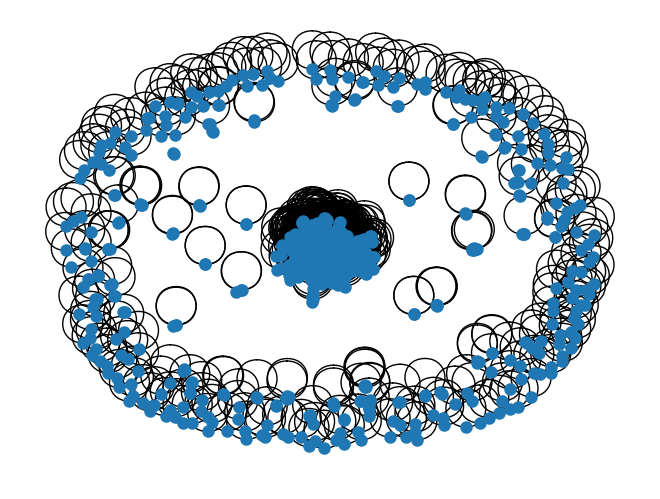

In [ ]:
unique_coms = np.unique(list(comms.values()))
unique_coms

pos = nx.spring_layout(g)
nx.draw(g, pos, node_size = 64, alpha = 1)
plt.show()

In [ ]:
comm_df = pd.DataFrame.from_dict(comms, orient="index").reset_index()
comm_df = comm_df.rename(columns={comm_df.columns[1]: "community", "index": "uid"})

In [ ]:
comm_df

,uid,community
0,66a62a489db3a1d1ed5ce194543d9a97,0
1,c7109572281e27d5ccd6bfb9ddc1da36,1
2,17bf22f44a91dcfd2f8aba76194ee55a,2
3,f41aee3c82cab6ea710b456c6f5ab0d2,3
4,738bb45d81a11e27dd84a1a61b8ebc10,2
...,...,...
1487,82399f40b4939a305459a71ecf7b2764,19
1488,b099dba3a9aae01ec0c475e8bc5d63f9,57
1489,bb1b0212786707c58876543647e9e652,47
1490,cf56ca29a3eee060955560ffb59dd1a6,27


In [ ]:
comm_24 = comm_df[comm_df.community.astype(str).isin(["4"])]
comm_24

,uid,community
7,12e4c0341686b27979f0de0e053fee84,4
8,7eace088762c02b6a033df8af6eff3a6,4
9,7e7627bb506df09e87804a5fad1847cd,4
10,783b3ab51d344ff2aa308355648467c3,4
30,1ab07293efa73cfba8fd2c91e6a55f97,4
48,9204e861f3ab6cf3a3e6fc07121f3910,4
49,8d754fd559d5a5ee01c6dc7d2449ab74,4
89,2e97fd4eccdaad350025ddb2401c958b,4
90,5d6b6b66b87f021b83427533f3352037,4
98,76aa74ab29f48e435cd10711254b7895,4


In [ ]:
review_comms = df[df.tracking_id.isin(["ebf4a9f606deca124f12111f5873b0c5"])]
review_comms

,tracking_id,uid,first_name,last_name,birth_year,officer_division,officer_sub_division_a,rank_desc,citizen_age,citizen_sex,citizen_race,allegation,allegation_directive,occurred_date,county,count
